# Exploring loss functions for the MNIST_SAMPLE dataset

**Objective:** In this notebook, I want to move towards classifying the full MNIST dataset of ten digits by first working with different loss functions for the smaller MNIST_SAMPLE dataset. The MNIST_SAMPLE dataset has data only for two digits (3s and 7s). The loss functions I explore are the `mnist_loss`, `softmax_loss`, and `cross_entropy_loss`. The reference for everything in this blog post is the [fastai 2020 course](https://course.fast.ai), especially the [amazing textbook](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527).

In Chapter 4 of the textbook, we are taught how to get the data ready and to use the `mnist_loss` function that basically uses the `sigmoid` function on one column of activations from the final layer. Then, in Chapter 5, we are given examples of how to use the `softmax` function to achieve what the `sigmoid` function does, but on more than one column of activations. Moreover, the `cross_entropy_loss` function is introduced. This function basically adds a `log` to the `softmax` function, i.e. it does a `log_softmax` on the final layer of activations followed by selecting the loss corresponding to the column that corresponds to the target (using `nll_loss`). 

In this notebook, I want to learn how to use a loss function that will work with more than one column of activations from the final layer. With the MNIST_FULL dataset, my thinking is that it would be better to have ten columns of activations from the final layer as opposed to one really long column of activations. And beyond this, as per Chatper 5 in the textbook, we should use the `cross_entropy_loss` to aid classification among ten categories of images. Here, I want to understand the details of this planned approach and validate it with two digits before moving to classify data from ten digits.

### Get the basic imports out of the way

In [2]:
from fastai.vision.all import *

In [3]:
import fastbook
fastbook.setup_book()
from fastbook import *

### Get your data ready

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

(#4) [Path('/home/igolgi/.fastai/data/mnist_sample/valid'),Path('/home/igolgi/.fastai/data/mnist_sample/labels.csv'),Path('/home/igolgi/.fastai/data/mnist_sample/train'),Path('/home/igolgi/.fastai/data/mnist_sample/models')]

In [5]:
three_imgs = (path/'train'/'3').ls().sorted()
seven_imgs = (path/'train'/'7').ls().sorted()

three_tensors_list = [tensor(Image.open(img)) for img in three_imgs]
seven_tensors_list = [tensor(Image.open(img)) for img in seven_imgs]

stacked_threes = torch.stack(three_tensors_list).float()/255.
stacked_sevens = torch.stack(seven_tensors_list).float()/255.
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

<AxesSubplot:>

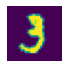

In [126]:
show_image(three_tensors_list[0])

<AxesSubplot:>

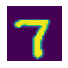

In [127]:
show_image(seven_tensors_list[0])

In [6]:
train_x = torch.cat([stacked_threes, stacked_sevens]); train_x.shape

torch.Size([12396, 28, 28])

In [7]:
train_x = train_x.view(-1, 28*28); train_x.shape

torch.Size([12396, 784])

In [8]:
train_y = tensor( [1]*len(three_imgs) + [0]*len(seven_imgs) ).unsqueeze(1); train_y.shape

torch.Size([12396, 1])

In [9]:
valid_three_imgs = (path/'train'/'3').ls().sorted()
valid_seven_imgs = (path/'train'/'7').ls().sorted()

valid_three_tensors_list = [tensor(Image.open(img)) for img in valid_three_imgs]
valid_seven_tensors_list = [tensor(Image.open(img)) for img in valid_seven_imgs]

valid_stacked_threes = torch.stack(valid_three_tensors_list).float()/255.
valid_stacked_sevens = torch.stack(valid_seven_tensors_list).float()/255.
valid_stacked_threes.shape, valid_stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [10]:
valid_x = torch.cat([valid_stacked_threes, valid_stacked_sevens]).view(-1, 28*28); valid_x.shape

torch.Size([12396, 784])

In [11]:
valid_y = tensor( [1]*len(valid_three_imgs) + [0]*len(valid_seven_imgs) ).unsqueeze(1); valid_y.shape

torch.Size([12396, 1])

### Prepare the dataset and dataloaders

In [12]:
dset = list(zip(train_x, train_y))
valid_dset = list(zip(valid_x, valid_y))

In [13]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)
dls = DataLoaders(dl, valid_dl)

### Get a basic linear classifier going as well as the loss functions, optimizers and metric functions

In [14]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [128]:
def linear1(xb, weights, bias): return xb@weights + bias # linear classifier with one weight per pixel

In [16]:
def mnist_loss(preds, tgts):
    preds = preds.sigmoid()
    return torch.where(tgts==1, 1-preds, preds).mean()

In [17]:
def cross_entropy_loss(preds, tgts):
    preds = torch.softmax(preds, dim=1)
    log_preds = torch.log(preds)
    #print(preds.shape, preds[0], preds[:,0].shape[0])
    return F.nll_loss(log_preds, torch.squeeze(tgts))

In [129]:
def softmax_loss(preds, tgts):
    preds = torch.softmax(preds, dim=1)
    idx = range(preds[:,0].shape[0])
    return preds[idx, torch.squeeze(tgts)].mean()

In [19]:
def calc_grad_mnist_loss(xb, yb, model, params):
    preds = model(xb, params[0], params[1])
    loss = mnist_loss(preds, yb)
    loss.backward()

In [20]:
def calc_grad_ce_loss(xb, yb, model, params):
    preds = model(xb, params[0], params[1])
    loss = cross_entropy_loss(preds, yb)
    #print(loss)
    loss.backward()

In [21]:
def calc_grad_softmax_loss(xb, yb, model, params):
    preds = model(xb, params[0], params[1])
    loss = softmax_loss(preds, yb)
    #print(loss)
    loss.backward()

In [22]:
def step_weights(params, lr):
    for p in params:
        p.data -= p.grad*lr
        p.grad.zero_()

In [23]:
def train_epoch(model, lr, params, calc_grad_func):
    for xb,yb in dl:
        calc_grad_func(xb,yb,model,params)
        step_weights(params,lr)

In [24]:
def batch_accuracy(xb,yb, mnist=True):
    if mnist:
        preds = xb.sigmoid()
        correct = (preds>0.5) == yb
    else:
        preds = torch.softmax(xb, dim=1)
        yb_squeezed = torch.squeeze(yb)
        #print(xb.shape, yb.shape, preds.shape, yb_squeezed.shape)
        correct = (preds[:,0]>0.5) == yb_squeezed
    return correct.float().mean()

In [25]:
def validate_epoch(model, params, mnist=True):
    accs = [batch_accuracy(model(xb, params[0], params[1]), yb, mnist) for xb,yb in valid_dl]
    if mnist:
        return round(torch.stack(accs).mean().item(), 4)
    else:
        accs_tensor = tensor(accs)
        #print(len(accs), accs[0], accs_tensor[0], accs_tensor.mean())
        accuracy = round(accs_tensor.mean().item(), 4)
        #print("Accuracy: ", accuracy)
        return accuracy

### Now, lets use mnist_loss and one column of activations

In [26]:
weights = init_params((28*28,1))
bias = init_params(1)
lr = 1.0
params = [weights, bias]
for i in range(10):
    train_epoch(linear1, lr, params, calc_grad_mnist_loss)
    print(validate_epoch(linear1, params), end=' ')

0.7205 0.8401 0.8998 0.9242 0.9381 0.9464 0.9534 0.9573 0.9608 0.9628 

### Now let's use cross_entropy_loss and two columns of activations

In [28]:
weights = init_params((28*28,2))
bias = init_params(2)
lr = 1.0
params = [weights, bias]
print(weights.shape, bias.shape)
for i in range(10):
    train_epoch(linear1, lr, params, calc_grad_ce_loss)
    print(validate_epoch(linear1, params, False), end=' ')

torch.Size([784, 2]) torch.Size([2])
0.5112 0.5112 0.5112 0.5112 0.5112 0.5112 0.5112 0.5112 0.5112 0.5112 

#### We see that the `batch_accuracy` function is not increasing at all. We need to debug what is going on here.

### Debug why the batch accuracy is not changing when we use cross entropy loss

In [30]:
x,y = dl.one_batch()

In [31]:
x.shape, y.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [32]:
w = init_params((28*28,2)); b = init_params(2); w.shape, b.shape

(torch.Size([784, 2]), torch.Size([2]))

In [33]:
preds = linear1(x, w, b); preds[:,0].shape[0]

256

In [34]:
preds[0]

tensor([-1.7301,  4.6855], grad_fn=<SelectBackward>)

In [35]:
loss = cross_entropy_loss(preds, y); loss

tensor(1.0518, grad_fn=<NllLossBackward>)

In [36]:
loss.backward()

In [37]:
params = w,b
for p in params:
    #print(p.grad, p.grad.mean())
    p.data -= p.grad*lr
    p.grad.zero_()

In [38]:
batch_accuracy(preds, y, False)

tensor(0.2188)

In [39]:
w = init_params((28*28,2)); b = init_params(2); print(w.shape, b.shape)
lr = 0.1

torch.Size([784, 2]) torch.Size([2])


In [81]:
def softmax_loss(preds, tgts):
    preds = torch.softmax(preds, dim=1)
    #print(preds.shape, preds[0], preds[:,0].shape[0])
    idx = range(preds[:,0].shape[0])
    return preds[idx, torch.squeeze(tgts)].mean()

In [41]:
def cross_entropy_loss(preds, tgts):
    preds = torch.softmax(preds, dim=1)
    log_preds = torch.log(preds)
    #print(preds.shape, preds[0], preds[:,0].shape[0])
    #return F.nll_loss(log_preds, torch.squeeze(tgts)) # This is the culprit!
    idx = range(log_preds[:,0].shape[0])
    return log_preds[idx, torch.squeeze(tgts)].mean()

In [42]:
def calc_grad_single(x1, y1, w1, b1):
    preds = linear1(x1, w1, b1);
    loss = softmax_loss(preds, y1); 
    #print("Loss: ", loss)
    loss.backward()
    return loss

In [43]:
def step_weights_single(p):
    p_grad_mean = p.grad.mean()
    p.data -= p.grad*lr
    p.grad.zero_()
    return p_grad_mean

In [44]:
def train_epoch_single():
    max_batches = 5
    cur_batch = 0
    batch_loss = []
    for xb, yb in dl:
        batch_loss.append(calc_grad_single(xb, yb, w, b))
        w_grad_mean = step_weights_single(w)
        b_grad_mean = step_weights_single(b)
        #print("Weights.grad.mean and bias.grad.mean: ", w_grad_mean, b_grad_mean)
        cur_batch += 1
        #if cur_batch >= max_batches:
        #    break
    batch_loss_tensor = tensor(batch_loss)
    print("Mean loss: ", batch_loss_tensor.mean())

In [45]:
def batch_accuracy_single(xb, yb):
    preds = torch.softmax(xb, dim=1)
    yb_squeezed = torch.squeeze(yb)
    #print(xb.shape, yb.shape, preds.shape, yb_squeezed.shape)
    correct = (preds[:,0]>0.5) == yb_squeezed
    return correct.float().mean()

In [46]:
def validate_epoch_single(model):
    accs = [batch_accuracy_single(model(xb,w,b), yb) for xb,yb in valid_dl]
    accs_tensor = tensor(accs)
    #print(len(accs), accs[0], accs_tensor[0], accs_tensor.mean())
    accuracy = round(accs_tensor.mean().item(), 4)
    print("Accuracy: ", accuracy)
    return accuracy

In [47]:
w = init_params((28*28,2)); b = init_params(2); print(w.shape, b.shape)
lr = 0.1
for i in range(10):
    train_epoch_single()
    validate_epoch_single(linear1)

torch.Size([784, 2]) torch.Size([2])
Mean loss:  tensor(0.6547)
Accuracy:  0.425
Mean loss:  tensor(0.5197)
Accuracy:  0.5398
Mean loss:  tensor(0.4005)
Accuracy:  0.6602
Mean loss:  tensor(0.2695)
Accuracy:  0.7681
Mean loss:  tensor(0.1824)
Accuracy:  0.8331
Mean loss:  tensor(0.1432)
Accuracy:  0.8711
Mean loss:  tensor(0.1168)
Accuracy:  0.8934
Mean loss:  tensor(0.1001)
Accuracy:  0.9078
Mean loss:  tensor(0.0886)
Accuracy:  0.9191
Mean loss:  tensor(0.0804)
Accuracy:  0.9267


**Observation:** when we use softmax as a loss function, the behavior is as expected, i.e. the loss goes down and the `batch_accuracy` goes up. But with `cross_entropy_loss`, the `batch_accuracy` stays constant. Why? Needs to be investigated further. For now, we plan to use `softmax_loss` till we figure out why going forward with MNIST_FULL.

In [48]:
weights = init_params((28*28,2))
bias = init_params(2)
lr = 1.0
params = [weights, bias]
print(weights.shape, bias.shape)
for i in range(10):
    train_epoch(linear1, lr, params, calc_grad_softmax_loss)
    print(validate_epoch(linear1, params, False), end=' ')

torch.Size([784, 2]) torch.Size([2])
0.6858 0.8494 0.913 0.9315 0.9449 0.9523 0.9563 0.9603 0.9619 0.9642 

### Conclusion

I could not get the traditional `cross_entropy_loss` using the negative log-likelihood function to work as expected with the MNIST_SAMPLE dataset of '3's and '7's and two columns of activations from the final layer. This is, in all likelihood, due to my inability to define the `batch_accuracy` function correctly? Using the `softmax_loss` alone on the other hand works as expected.

### Now, let's replace our code with PyTorch/fastai built-in functions and see if we get the same result

In [49]:
linear2 = nn.Linear(28*28, 2)
w,b = linear2.parameters(); w.shape, b.shape

(torch.Size([2, 784]), torch.Size([2]))

Lets put our step_weights function into a class

In [50]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr
        
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [51]:
opt = BasicOptim(linear2.parameters(), lr)

Lets redefine our loss functions to match the template expected by fastai and PyTorch. Lets also redefine the `train_epoch` function to use the optimizer defined above.

In [99]:
def softmax_loss(preds, tgts):
    preds = torch.softmax(preds, dim=1)
    #print(preds[0])
    idx = range(preds[:,0].shape[0])
    return preds[idx, torch.squeeze(tgts)].mean()

In [87]:
def calc_grad_mnist_loss(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()
    return loss

In [88]:
def calc_grad_ce_loss(xb, yb, model):
    preds = model(xb)
    loss = cross_entropy_loss(preds, yb)
    #print(loss)
    loss.backward()
    return loss

In [89]:
def calc_grad_softmax_loss(xb, yb, model):
    preds = model(xb)
    loss = softmax_loss(preds, yb)
    #print(loss)
    loss.backward()
    return loss

In [90]:
def train_epoch(model, calc_grad_func):
    epoch_loss = []
    for xb,yb in dl:
        epoch_loss.append(calc_grad_func(xb,yb,model))
        opt.step()
        opt.zero_grad()
    epoch_loss_tnsr = tensor(epoch_loss)
    return epoch_loss_tnsr.mean()

We need to redefine the validate_epoch function simply because we don't need to pass the params as args to the built-in Pytorch function

In [138]:
def validate_epoch_new(model, mnist=True):
    accs = [batch_accuracy(model(xb), yb, mnist) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [58]:
validate_epoch_new(linear2, False)

0.6437

In [63]:
train_epoch(linear2, calc_grad_softmax_loss)

In [139]:
def train_model(model, epochs, mnist=True):
    for i in range(epochs):
        if mnist:
            epoch_loss_mean = train_epoch(model, calc_grad_mnist_loss)
        else:
            epoch_loss_mean = train_epoch(model, calc_grad_softmax_loss)
        #print(epoch_loss_mean)
        print(validate_epoch_new(model, mnist), end=' ')

In [140]:
# mnist_loss
lr = 1.
linear2 = nn.Linear(28*28,1)
#opt = SGD(linear2.parameters(), lr)
opt = BasicOptim(linear2.parameters(), lr)
train_model(linear2, 10, True)

0.4888 0.8616 0.8242 0.9001 0.9282 0.944 0.9525 0.9581 0.9636 0.9676 

In [141]:
# softmax_loss
lr = 0.1
linear3 = nn.Linear(28*28,2)
#opt = SGD(linear3.parameters(), lr)
opt = BasicOptim(linear3.parameters(), lr)
train_model(linear3, 10, False)

0.5217 0.8304 0.9157 0.9427 0.9552 0.9628 0.9674 0.9707 0.9723 0.9737 

A simple replacement we can make for our BasicOptim optimizer class is to replace it with the built-in SGD optimizer function

In [142]:
# mnist_loss
lr = 1.
linear2 = nn.Linear(28*28,1)
opt = SGD(linear2.parameters(), lr)
train_model(linear2, 10, True)

0.4888 0.7525 0.8579 0.9094 0.9333 0.9467 0.9546 0.9595 0.9648 0.9688 

In [143]:
# softmax_loss
lr = 0.1
linear3 = nn.Linear(28*28,2)
opt = SGD(linear3.parameters(), lr)
train_model(linear3, 10, False)

0.5363 0.8386 0.9193 0.9441 0.955 0.9636 0.9671 0.9698 0.9718 0.9733 

Instead of `train_model`, we can now transition over to using the built-in `Learner.fit` class method. Before we do this, lets redefine batch_accuracy for mnist and softmax separately as there is a need to follow the template here for this method

In [112]:
def batch_accuracy_mnist(xb,yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [113]:
def batch_accuracy_softmax(xb,yb):
    preds = torch.softmax(xb, dim=1)
    yb_squeezed = torch.squeeze(yb)
    #print(xb.shape, yb.shape, preds.shape, yb_squeezed.shape)
    correct = (preds[:,0]>0.5) == yb_squeezed
    return correct.float().mean()

In [114]:
learn_mnist = Learner(dls, nn.Linear(28*28,1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy_mnist)

In [115]:
learn_softmax = Learner(dls, nn.Linear(28*28,2), opt_func=SGD, loss_func=softmax_loss, metrics=batch_accuracy_softmax)

In [116]:
learn_mnist.fit(10, lr=1.0)

epoch,train_loss,valid_loss,batch_accuracy_mnist,time
0,0.637177,0.504163,0.494595,00:00
1,0.506652,0.218602,0.804453,00:00
2,0.187165,0.177797,0.836641,00:00
3,0.082407,0.109837,0.902065,00:00
4,0.043772,0.081640,0.928929,00:00
5,0.028667,0.065939,0.944256,00:00
6,0.022442,0.055925,0.952323,00:00
7,0.019662,0.048953,0.958454,00:00
8,0.018244,0.043798,0.963779,00:00
9,0.017387,0.039850,0.967570,00:00


In [117]:
learn_softmax.fit(10, lr=0.1)

epoch,train_loss,valid_loss,batch_accuracy_softmax,time
0,0.164560,0.393483,0.524685,00:00
1,0.089713,0.191804,0.841884,00:00
2,0.060771,0.111265,0.918361,00:00
3,0.047979,0.080447,0.942965,00:00
4,0.041427,0.064905,0.954743,00:00
5,0.037578,0.055631,0.962085,00:00
6,0.035008,0.049473,0.966602,00:00
7,0.033112,0.045073,0.970152,00:00
8,0.031616,0.041761,0.971442,00:00
9,0.030383,0.039169,0.973459,00:00


### Using a neural network instead of a linear classifier

In [144]:
simple_net_mnist = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1) # 1 column of activations from the final layer
)

In [145]:
simple_net_softmax = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,2) # 2 columns of activations from the final layer
)

In [146]:
learn_mnist = Learner(dls, simple_net_mnist, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy_mnist)

In [147]:
learn_softmax = Learner(dls, simple_net_softmax, opt_func=SGD, loss_func=softmax_loss, metrics=batch_accuracy_softmax)

In [148]:
learn_mnist.fit(20, 0.1)

epoch,train_loss,valid_loss,batch_accuracy_mnist,time
0,0.298082,0.406346,0.506050,00:00
1,0.140334,0.229533,0.802194,00:00
2,0.078882,0.120482,0.906986,00:00
3,0.052542,0.082606,0.937964,00:00
4,0.040197,0.064589,0.950307,00:00
5,0.033815,0.054133,0.959180,00:00
6,0.030114,0.047274,0.964343,00:00
7,0.027690,0.042405,0.967328,00:00
8,0.025933,0.038752,0.969990,00:00
9,0.024566,0.035897,0.972088,00:00


In [149]:
learn_softmax.fit(20, 0.1)

epoch,train_loss,valid_loss,batch_accuracy_softmax,time
0,0.248439,0.425511,0.505566,00:00
1,0.115231,0.213843,0.813892,00:00
2,0.063572,0.113364,0.907632,00:00
3,0.042388,0.079075,0.936189,00:00
4,0.032682,0.062401,0.950065,00:00
5,0.027737,0.052443,0.957567,00:00
6,0.024883,0.045787,0.963053,00:00
7,0.023011,0.040991,0.966925,00:00
8,0.021647,0.037365,0.969426,00:00
9,0.020583,0.034523,0.971846,00:00


### Pretty cool accuracy numbers there! :-)